## Bureau datasets - new_bureau_df

In [46]:
import pandas as pd
import numpy as np
from functions import missing_values_table, imbalance_feature_checker, unique_values_counter
from functions import feature_deletor, fill_nan, convert_to_year

import warnings
warnings.filterwarnings('ignore')

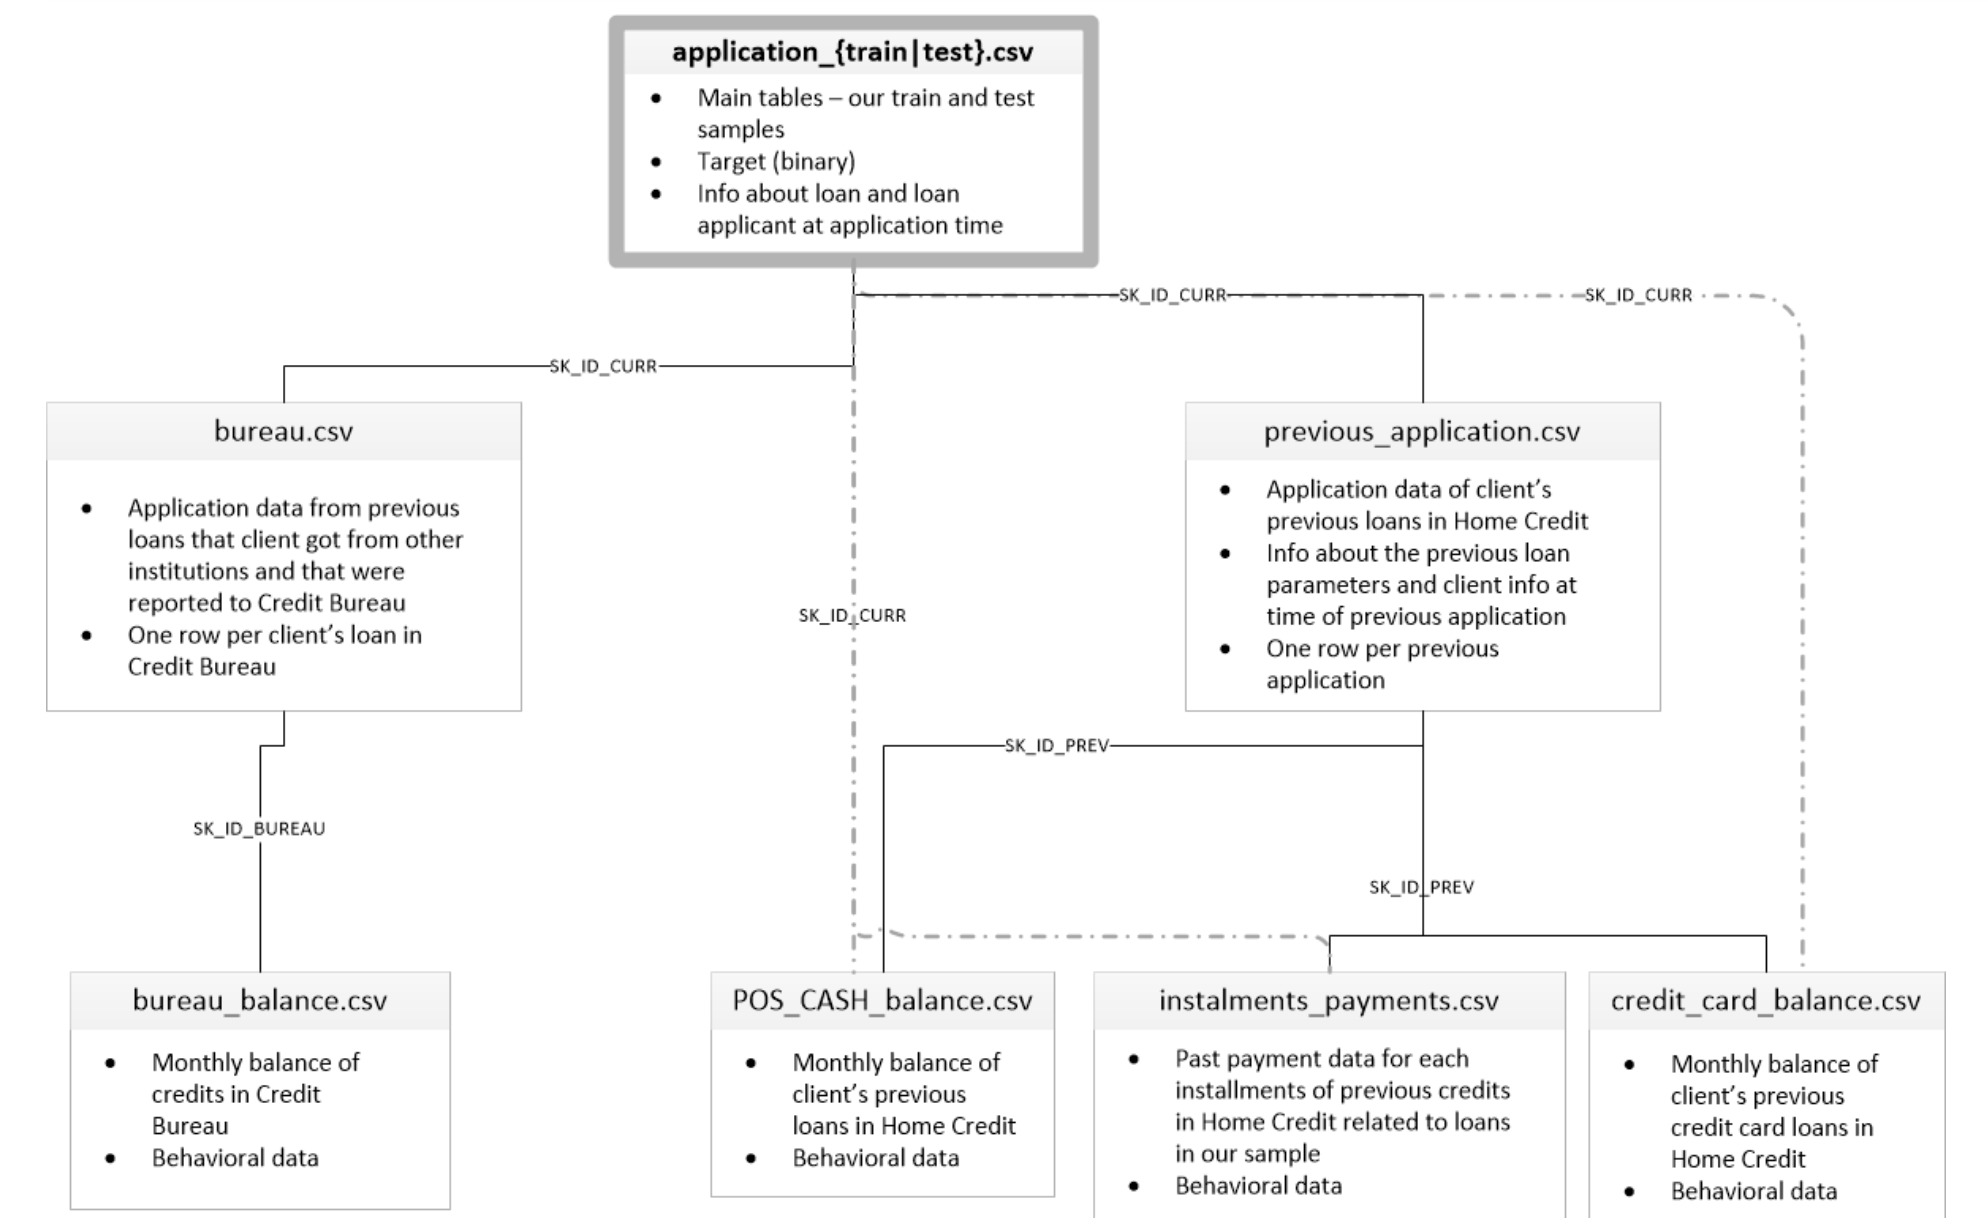

In [3]:
bureau = pd.read_csv('../data/processData/bureau.csv')
bureau_balance = pd.read_csv('../data/processData/bureau_balance.csv')

### Bureau balance dataset

In [4]:
bureau_balance['Months from today'] = bureau_balance['MONTHS_BALANCE']*-1

In [5]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,Months from today
0,5715448,0,C,0
1,5715448,-1,C,1
2,5715448,-2,C,2
3,5715448,-3,C,3
4,5715448,-4,C,4
...,...,...,...,...
27299920,5041336,-47,X,47
27299921,5041336,-48,X,48
27299922,5041336,-49,X,49
27299923,5041336,-50,X,50


In [6]:
bureau_balance.SK_ID_BUREAU.nunique()

817395

**STATUS**: Status of Credit Bureau loan during the month.
* **C** means closed
* **X** means status unknown
* **0** means no DPD
* **1** means maximal did during month between 1-30
* **2** means DPD 31-60
* **3** means DPD 61-90
* **4** means DPD 91-120
* 5 means DPD 120+ or sold or written off

In [7]:
bureau_balance.STATUS.value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [8]:
bureau_balance['STATUS'].replace({'C': 0, 'X' : -1}, inplace=True)
bureau_balance['STATUS'] = bureau_balance['STATUS'].astype('int')
bureau_balance['STATUS'].replace({1: 1, 2 : 1, 3: 1, 4: 1, 5: 1}, inplace=True)

In [9]:
bureau_balance.STATUS.value_counts(normalize=True)

STATUS
 0    0.774599
-1    0.212839
 1    0.012562
Name: proportion, dtype: float64

In [10]:
new_bureau_balance = bureau_balance.groupby('SK_ID_BUREAU').agg(max).reset_index()
new_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,Months from today
0,5001709,0,0,96
1,5001710,0,0,82
2,5001711,0,0,3
3,5001712,0,0,18
4,5001713,0,-1,21


In [14]:
missing_values_table(new_bureau_balance, select_numerical=True)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [16]:
imbalance_feature_checker(new_bureau_balance, select_numerical=True)

Your selected dataframe has 4 columns.
There are 0 columns that are imbalance.


,Value


In [17]:
new_bureau_balance.STATUS.value_counts(normalize=True)

STATUS
 0    0.768982
 1    0.126333
-1    0.104685
Name: proportion, dtype: float64

### Bureau dataset

* Numirecal features

In [18]:
bureau[bureau.select_dtypes('number').columns].head(5)

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN


In [19]:
bureau.shape[0], bureau.SK_ID_CURR.nunique(), bureau.SK_ID_BUREAU.nunique()

(1716428, 305811, 1716428)

In [20]:
num_missing_values = missing_values_table(bureau, select_numerical=True)
num_missing_values

Your selected dataframe has 14 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


In [23]:
num_cls_nan_delete = num_missing_values[num_missing_values['% of Total Values'] > 40.00].index.tolist()
bureau = feature_deletor(bureau, cols = num_cls_nan_delete)

In [26]:
bureau = fill_nan(bureau, select_numerical=True)

* Umbalance feature:

In [27]:
imbalanced_num_feature = imbalance_feature_checker(bureau, select_numerical=True)
imbalanced_num_feature

Your selected dataframe has 12 columns.
There are 3 columns that are imbalance.


,Value
CREDIT_DAY_OVERDUE,0.997543
CNT_CREDIT_PROLONG,0.994690
AMT_CREDIT_SUM_OVERDUE,0.997578


In [28]:
bureau = feature_deletor(bureau, imbalanced_num_feature.index.tolist())

* **DAYS_CREDIT:** How many days before current application did client apply for Credit Bureau credit
* **DAYS_CREDIT_ENDDATE:** Remaining duration of CB credit (in days) at the time of application in Home Credit
* DAYS_CREDIT_UPDATE: How many days before loan application did last information about the Credit Bureau credit come

In [29]:
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE']]

,DAYS_CREDIT,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE
0,-497,-131,-153.000000
1,-208,-20,1075.000000
2,-203,-16,528.000000
3,-203,-16,510.517362
4,-629,-21,1197.000000
...,...,...,...
1716423,-44,-19,-30.000000
1716424,-2648,-2493,-2433.000000
1716425,-1809,-967,-1628.000000
1716426,-1878,-1508,-1513.000000


In [32]:
bureau = convert_to_year(bureau, ['DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE'])

bureau[['DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE']]

,DAYS_CREDIT,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ENDDATE
0,2.0,1.0,1.0
1,1.0,1.0,-2.0
2,1.0,1.0,-1.0
3,1.0,1.0,-1.0
4,2.0,1.0,-3.0
...,...,...,...
1716423,1.0,1.0,1.0
1716424,8.0,7.0,7.0
1716425,5.0,3.0,5.0
1716426,6.0,5.0,5.0


* Object features

In [33]:
missing_values_table(bureau, select_numerical=False)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [34]:
imbalance_table = imbalance_feature_checker(bureau, select_numerical=False)
imbalance_table

Your selected dataframe has 3 columns.
There are 1 columns that are imbalance.


,Value
CREDIT_CURRENCY,0.99918


In [35]:
imbalance_cols = imbalance_table.index.tolist()
bureau = feature_deletor(bureau, imbalance_cols )

In [36]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,2.0,1.0,-153.000000,91323.00,0.000000,6229.51498,Consumer credit,1.0
1,215354,5714463,Active,1.0,-2.0,-1017.437148,225000.00,171342.000000,6229.51498,Credit card,1.0
2,215354,5714464,Active,1.0,-1.0,-1017.437148,464323.50,137085.119952,6229.51498,Consumer credit,1.0
3,215354,5714465,Active,1.0,-1.0,-1017.437148,90000.00,137085.119952,6229.51498,Credit card,1.0
4,215354,5714466,Active,2.0,-3.0,-1017.437148,2700000.00,137085.119952,6229.51498,Consumer credit,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,1.0,1.0,-1017.437148,11250.00,11250.000000,0.00000,Microloan,1.0
1716424,100044,5057754,Closed,8.0,7.0,-2493.000000,38130.84,0.000000,0.00000,Consumer credit,7.0
1716425,100044,5057762,Closed,5.0,5.0,-970.000000,15570.00,137085.119952,6229.51498,Consumer credit,3.0
1716426,246829,5057770,Closed,6.0,5.0,-1513.000000,36000.00,0.000000,0.00000,Consumer credit,5.0


**Merge datasets**

In [37]:
bureau_df = bureau.join(new_bureau_balance.set_index('SK_ID_BUREAU'), on='SK_ID_BUREAU', how='inner')
bureau_df

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,STATUS,Months from today
768,380361,5715448,Active,3.0,-85.0,-1017.437148,67500.0,0.000000,67500.00000,Credit card,1.0,0,0,26
769,380361,5715449,Active,1.0,-3.0,-1017.437148,45000.0,0.000000,45000.00000,Credit card,1.0,0,0,11
770,380361,5715451,Closed,3.0,1.0,-759.000000,74439.0,0.000000,0.00000,Consumer credit,3.0,-5,0,30
771,380361,5715452,Closed,3.0,-84.0,-831.000000,315000.0,0.000000,0.00000,Credit card,3.0,0,0,32
772,380361,5715453,Closed,4.0,-1.0,-780.000000,2025000.0,0.000000,0.00000,Consumer credit,3.0,0,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716288,229054,5053730,Active,2.0,-3.0,-1017.437148,67500.0,63530.460000,3969.54000,Credit card,1.0,0,0,14
1716289,254479,5053734,Active,5.0,-2.0,-1017.437148,142294.5,137085.119952,6229.51498,Consumer credit,1.0,0,0,51
1716290,363575,5053740,Closed,4.0,2.0,-502.000000,900000.0,0.000000,0.00000,Consumer credit,2.0,0,0,40
1716291,245498,5053747,Closed,8.0,7.0,-2018.000000,49495.5,0.000000,0.00000,Consumer credit,6.0,0,0,84


* Process num features

In [38]:
bureau_df_num = bureau_df.groupby('SK_ID_CURR').agg({'DAYS_CREDIT': 'mean',
                                                     'DAYS_CREDIT_ENDDATE': 'mean',
                                                     'DAYS_ENDDATE_FACT': 'mean',
                                                     'AMT_CREDIT_SUM': 'mean',
                                                     'AMT_CREDIT_SUM_DEBT': 'mean',
                                                     'AMT_CREDIT_SUM_LIMIT': 'mean',
                                                     'DAYS_CREDIT_UPDATE': 'mean',
                                                     'MONTHS_BALANCE': 'mean',
                                                     'STATUS': 'mean',
                                                     'Months from today': 'mean'}).reset_index()

In [39]:
bureau_df_num.sample(5)

,SK_ID_CURR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,STATUS,Months from today
30353,180305,4.250000,1.250000,-1097.359287,2.402809e+05,123660.967488,3114.757490,3.000000,0.000000,0.0,43.250000
84591,323649,3.000000,2.333333,-688.000000,5.345280e+04,0.000000,4153.009987,2.333333,0.000000,1.0,28.333333
65647,273568,4.400000,0.200000,-1057.262289,1.915979e+06,154097.423990,54654.422996,2.000000,-25.600000,1.0,46.000000
60407,259594,4.400000,0.800000,-1048.731144,7.873927e+05,418673.285986,3114.757490,2.700000,0.000000,0.2,45.300000
11094,129019,2.666667,0.000000,-688.333333,5.442282e+04,91390.079968,6229.514980,1.666667,-3.333333,0.0,27.000000


* Process cat features

In [40]:
bureau_df[bureau_df.select_dtypes('object').columns].sample(5)

,CREDIT_ACTIVE,CREDIT_TYPE
436497,Active,Consumer credit
868026,Active,Consumer credit
376246,Closed,Consumer credit
1238416,Closed,Consumer credit
572902,Closed,Consumer credit


In [41]:
bureau_df_cat = pd.DataFrame()

bureau_df_cat['CREDIT_ACTIVE'] = bureau_df.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].transform(lambda x: x.mode().iloc[0])
bureau_df_cat['CREDIT_TYPE'] = bureau_df.groupby('SK_ID_CURR')['CREDIT_TYPE'].transform(lambda x: x.mode().iloc[0])

bureau_df_cat['SK_ID_CURR'] = bureau_df['SK_ID_CURR']
bureau_df_cat = bureau_df_cat.drop_duplicates(subset='SK_ID_CURR')
bureau_df_cat = bureau_df_cat.reset_index(drop=True)

In [42]:
bureau_df_cat

,CREDIT_ACTIVE,CREDIT_TYPE,SK_ID_CURR
0,Closed,Consumer credit,380361
1,Active,Consumer credit,125263
2,Active,Consumer credit,275240
3,Active,Credit card,399518
4,Closed,Consumer credit,215382
...,...,...,...
134537,Closed,Consumer credit,322864
134538,Closed,Consumer credit,207190
134539,Closed,Consumer credit,324956
134540,Closed,Consumer credit,345866


In [43]:
new_bureau_df = bureau_df_num.merge(bureau_df_cat.set_index('SK_ID_CURR'), on='SK_ID_CURR', how='inner')

In [44]:
new_bureau_df

,SK_ID_CURR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,STATUS,Months from today,CREDIT_ACTIVE,CREDIT_TYPE
0,100001,2.571429,0.285714,-907.758778,2.076236e+05,85240.928571,889.930711,1.000000,0.000000,0.142857,23.571429,Closed,Consumer credit
1,100002,2.875000,0.625000,-777.484287,1.081319e+05,82129.544982,7113.328115,2.125000,-15.500000,0.750000,28.250000,Closed,Consumer credit
2,100005,1.333333,-0.666667,-719.291432,2.190420e+05,189469.500000,0.000000,1.000000,0.000000,0.000000,6.000000,Active,Consumer credit
3,100010,6.000000,1.000000,-1077.718574,4.950000e+05,174003.750000,3114.757490,2.500000,-28.500000,0.000000,63.500000,Active,Consumer credit
4,100013,5.250000,3.250000,-1054.750000,5.180700e+05,102813.839964,6229.514980,2.750000,0.000000,0.500000,56.500000,Closed,Car loan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134537,456247,3.272727,-3.454545,-1066.573768,4.714057e+05,261710.509069,2831.597718,2.727273,-5.818182,0.000000,33.909091,Closed,Consumer credit
134538,456250,3.000000,-3.000000,-931.624765,1.028820e+06,744013.365000,19422.795000,1.000000,0.000000,0.000000,28.000000,Active,Consumer credit
134539,456253,2.750000,-0.500000,-905.718574,9.900000e+05,448958.250000,0.000000,1.250000,0.000000,0.000000,28.250000,Active,Consumer credit
134540,456254,4.000000,3.000000,-859.000000,4.500000e+04,0.000000,6229.514980,2.000000,0.000000,0.000000,36.000000,Closed,Consumer credit


In [47]:
# calcule the unique values of object features
unique_values_counter(new_bureau_df)

CREDIT_ACTIVE     4
CREDIT_TYPE      10
dtype: int64

In [48]:
new_bureau_df = pd.get_dummies(new_bureau_df, dtype=float)

In [50]:
path = '../data/cleanedData/'
new_bureau_df.to_csv(path + 'new_bureau_df.csv', index=False)